In [39]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [40]:
import numpy as np
import pandas as pd

In [41]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [91]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'epsilon', 'fit_time', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    if 'mean_train_n_iter' in cv_results.columns:
        filtered_cv_results['n_iter'] = cv_results['mean_train_n_iter'].round().astype(int)
    
    filtered_cv_results['nr_train_sv'] = cv_results['mean_train_nr_support_vectors'].round().astype(int)
    filtered_cv_results['nr_val_sv'] = cv_results['mean_test_nr_support_vectors'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [44]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [53]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'nr_support_vectors': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


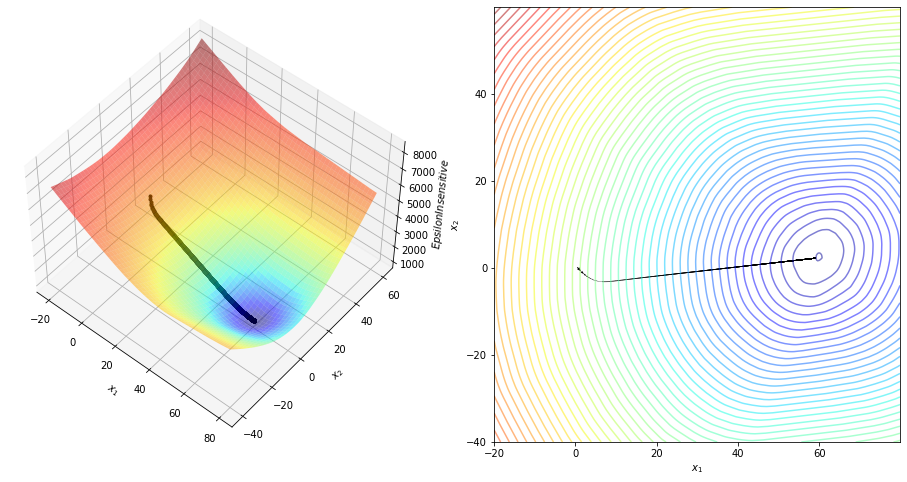

In [92]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, learning_rate=1., 
                              max_iter=4000, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_eps_loss.png')

In [93]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svr_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,nr_train_sv,nr_val_sv
adagrad,1,0.100000,0.743824,0.919139,0.915610,872,66,33
adagrad,1,0.200000,0.738437,0.919988,0.916497,885,66,33
adagrad,1,0.300000,0.698630,0.920124,0.916702,878,65,33
adagrad,10,0.100000,2.723583,0.977832,0.972861,3546,65,32
adagrad,10,0.200000,2.604949,0.977798,0.972835,3514,65,32
adagrad,10,0.300000,2.715705,0.977781,0.972876,3458,65,32
adagrad,100,0.100000,3.106563,0.978115,0.974270,3999,66,32
adagrad,100,0.200000,3.065408,0.978128,0.974186,3999,66,32
adagrad,100,0.300000,2.610475,0.978122,0.974216,3999,66,32


In [94]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [95]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,nr_train_sv,nr_val_sv
liblinear,1,0.100000,0.000909,0.918828,0.916845,12,66,33
liblinear,1,0.200000,0.000924,0.918753,0.916601,13,65,32
liblinear,1,0.300000,0.001215,0.919287,0.917030,10,66,32
liblinear,10,0.100000,0.001047,0.977848,0.972083,122,66,33
liblinear,10,0.200000,0.001276,0.977852,0.972041,164,64,33
liblinear,10,0.300000,0.001184,0.977871,0.972149,129,63,33
liblinear,100,0.100000,0.001624,0.977723,0.974270,735,65,33
liblinear,100,0.200000,0.001437,0.977641,0.973867,693,66,33
liblinear,100,0.300000,0.001536,0.977641,0.973903,808,65,33


In [96]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results, ignore_index=True)
primal_svr_eps_cv_results.sort_values(['epsilon', 'C', 'solver'], inplace=True)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', index=False)
primal_svr_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,nr_train_sv,nr_val_sv
adagrad,1,0.100000,0.743824,0.919139,0.915610,872,66,33
liblinear,1,0.100000,0.000909,0.918828,0.916845,12,66,33
adagrad,10,0.100000,2.723583,0.977832,0.972861,3546,65,32
liblinear,10,0.100000,0.001047,0.977848,0.972083,122,66,33
adagrad,100,0.100000,3.106563,0.978115,0.974270,3999,66,32
liblinear,100,0.100000,0.001624,0.977723,0.974270,735,65,33
adagrad,1,0.200000,0.738437,0.919988,0.916497,885,66,33
liblinear,1,0.200000,0.000924,0.918753,0.916601,13,65,32
adagrad,10,0.200000,2.604949,0.977798,0.972835,3514,65,32
liblinear,10,0.200000,0.001276,0.977852,0.972041,164,64,33


### Dual formulations

In [7]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_nonlinearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import GridSearchCV

In [8]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 18 candidates, totalling 54 fits


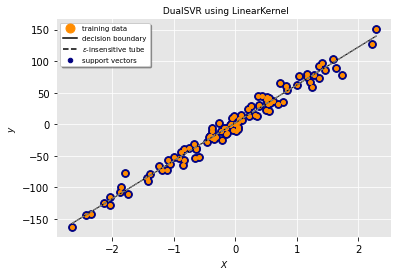

In [15]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [15]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
smo,1,0.100000,0.062739,0.917773,0.914442,66,66
cvxopt,1,0.100000,0.078818,0.917772,0.914479,67,67
smo,1,0.200000,0.070250,0.918341,0.915019,66,66
cvxopt,1,0.200000,0.083481,0.918341,0.915058,67,67
smo,1,0.300000,0.090543,0.918942,0.915576,66,66
cvxopt,1,0.300000,0.072449,0.918942,0.915614,66,66
smo,10,0.100000,0.117902,0.977920,0.972445,66,66
cvxopt,10,0.100000,0.028650,0.977920,0.972466,67,67
smo,10,0.200000,0.185026,0.977926,0.972457,65,65
cvxopt,10,0.200000,0.022306,0.977926,0.972474,67,67


In [16]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(SklSVR(kernel='linear'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [17]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
libsvm,1,0.100000,0.001410,0.917627,0.915448,66,66
libsvm,1,0.200000,0.000902,0.918194,0.915985,66,66
libsvm,1,0.300000,0.001214,0.918786,0.916554,66,66
libsvm,10,0.100000,0.001434,0.977852,0.972051,66,66
libsvm,10,0.200000,0.001295,0.977851,0.972025,65,65
libsvm,10,0.300000,0.001567,0.977870,0.972135,65,65
libsvm,100,0.100000,0.002421,0.977723,0.974270,66,66
libsvm,100,0.200000,0.002740,0.977673,0.974122,66,66
libsvm,100,0.300000,0.002715,0.977655,0.974045,66,66


In [113]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results, ignore_index=True)
linear_dual_svr_cv_results.sort_values(['epsilon', 'C', 'solver'], inplace=True)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', index=False)
linear_dual_svr_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
cvxopt,1,0.100000,0.078818,0.917772,0.914479,67,67
libsvm,1,0.100000,0.001410,0.917627,0.915448,66,66
smo,1,0.100000,0.062739,0.917773,0.914442,66,66
cvxopt,10,0.100000,0.028650,0.977920,0.972466,67,67
libsvm,10,0.100000,0.001434,0.977852,0.972051,66,66
smo,10,0.100000,0.117902,0.977920,0.972445,66,66
cvxopt,100,0.100000,0.014835,0.977788,0.974150,67,67
libsvm,100,0.100000,0.002421,0.977723,0.974270,66,66
smo,100,0.100000,0.612424,0.977788,0.974139,66,66
cvxopt,1,0.200000,0.083481,0.918341,0.915058,67,67


##### Nonlinear

Fitting 3 folds for each of 18 candidates, totalling 54 fits


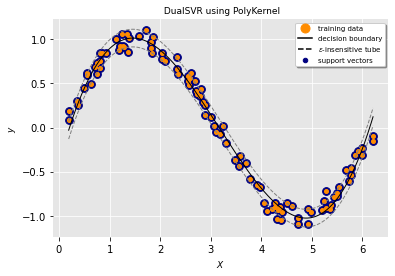

In [36]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

In [37]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
smo,poly,1,0.100000,53.515953,0.608115,-11.038409,18,18
cvxopt,poly,1,0.100000,0.012432,0.707388,-9.661920,18,18
smo,poly,1,0.200000,1.664332,-1.035163,-24.781445,5,5
cvxopt,poly,1,0.200000,0.010325,-0.191042,-11.162733,5,5
smo,poly,1,0.300000,1.282843,-0.584971,-16.758909,5,5
cvxopt,poly,1,0.300000,0.009855,0.126241,-8.585076,4,4
smo,poly,10,0.100000,246.714045,0.473550,-7.056016,17,17
cvxopt,poly,10,0.100000,0.009691,0.750677,-5.950599,17,17
smo,poly,10,0.200000,3.602219,-0.321932,-24.534883,4,4
cvxopt,poly,10,0.200000,0.011393,0.546714,-10.842683,4,4


Fitting 3 folds for each of 18 candidates, totalling 54 fits


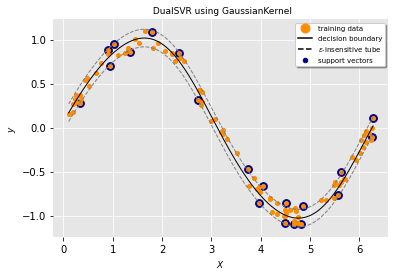

In [9]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [10]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
smo,rbf,1,0.100000,0.051685,0.981312,-0.523270,14,14
cvxopt,rbf,1,0.100000,0.023099,0.981651,-0.414322,14,14
smo,rbf,1,0.200000,0.026222,0.963877,-1.133633,5,5
cvxopt,rbf,1,0.200000,0.018508,0.968397,-1.008175,5,5
smo,rbf,1,0.300000,0.015314,0.925682,-1.696438,5,5
cvxopt,rbf,1,0.300000,0.021200,0.932699,-1.538800,5,5
smo,rbf,10,0.100000,0.229888,0.985327,0.147453,13,13
cvxopt,rbf,10,0.100000,0.018509,0.985561,0.108792,13,13
smo,rbf,10,0.200000,0.026772,0.955168,-1.139310,4,4
cvxopt,rbf,10,0.200000,0.015264,0.967099,-1.006287,5,5


In [38]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results, ignore_index=True)
custom_nonlinear_dual_svr_cv_results.sort_values(['epsilon', 'C', 'kernel', 'solver'], inplace=True)
custom_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
cvxopt,poly,1,0.100000,0.012432,0.707388,-9.661920,18,18
smo,poly,1,0.100000,53.515953,0.608115,-11.038409,18,18
cvxopt,rbf,1,0.100000,0.023099,0.981651,-0.414322,14,14
smo,rbf,1,0.100000,0.051685,0.981312,-0.523270,14,14
cvxopt,poly,10,0.100000,0.009691,0.750677,-5.950599,17,17
smo,poly,10,0.100000,246.714045,0.473550,-7.056016,17,17
cvxopt,rbf,10,0.100000,0.018509,0.985561,0.108792,13,13
smo,rbf,10,0.100000,0.229888,0.985327,0.147453,13,13
cvxopt,poly,100,0.100000,0.011202,0.858077,-5.630614,34,34
smo,poly,100,0.100000,2373.186796,0.448468,-6.958503,17,17


In [11]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(SklSVR(),
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [12]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
libsvm,poly,1,0.100000,0.048495,0.969950,-31.639597,26,26
libsvm,poly,1,0.200000,0.009272,0.949658,-77.766723,9,9
libsvm,poly,1,0.300000,0.004746,0.899052,-110.044559,7,7
libsvm,poly,10,0.100000,0.271278,0.974545,-19.141421,24,24
libsvm,poly,10,0.200000,0.012017,0.959396,-76.201228,4,4
libsvm,poly,10,0.300000,0.005744,0.911641,-109.999548,3,3
libsvm,poly,100,0.100000,1.376607,0.974419,-17.948798,24,24
libsvm,poly,100,0.200000,0.012390,0.960116,-76.187402,4,4
libsvm,poly,100,0.300000,0.006325,0.911641,-109.999548,3,3
libsvm,rbf,1,0.100000,0.002932,0.981854,-1.495513,16,16


In [17]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results, ignore_index=True)
nonlinear_dual_svr_cv_results.sort_values(['epsilon', 'C', 'kernel', 'solver'], inplace=True)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', index=False)
nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
cvxopt,poly,1,0.100000,0.020200,0.912871,-11.755067,25,25
libsvm,poly,1,0.100000,0.048495,0.969950,-31.639597,26,26
smo,poly,1,0.100000,89.065522,0.912118,-12.565930,26,26
cvxopt,rbf,1,0.100000,0.023099,0.981651,-0.414322,14,14
libsvm,rbf,1,0.100000,0.002932,0.981854,-1.495513,16,16
smo,rbf,1,0.100000,0.051685,0.981312,-0.523270,14,14
cvxopt,poly,10,0.100000,0.012495,0.306857,-6.842633,25,25
libsvm,poly,10,0.100000,0.271278,0.974545,-19.141421,24,24
smo,poly,10,0.100000,388.475776,0.638964,-8.268856,24,24
cvxopt,rbf,10,0.100000,0.018509,0.985561,0.108792,13,13


#### Lagrangian Dual

##### Linear

In [18]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [19]:
linear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
linear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
qp,1,0.100000,0.780047,0.876534,0.870926,67,67
qp,1,0.200000,0.839346,0.876534,0.870927,67,67
qp,1,0.300000,0.728524,0.876534,0.870927,67,67
qp,10,0.100000,0.536102,0.731825,0.722021,67,67
qp,10,0.200000,0.539040,0.731825,0.722021,67,67
qp,10,0.300000,0.522731,0.731825,0.722020,67,67
qp,100,0.100000,0.490871,0.731825,0.722021,67,67
qp,100,0.200000,0.495237,0.731825,0.722021,67,67
qp,100,0.300000,0.410422,0.731825,0.722020,67,67


In [21]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [22]:
linear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
linear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
bcqp,1,0.100000,0.840952,0.731073,0.721200,67,67
bcqp,1,0.200000,0.880100,0.731073,0.721199,67,67
bcqp,1,0.300000,0.884336,0.731073,0.721199,67,67
bcqp,10,0.100000,0.849611,0.733638,0.723925,67,67
bcqp,10,0.200000,0.778322,0.733638,0.723924,67,67
bcqp,10,0.300000,0.762222,0.733638,0.723924,67,67
bcqp,100,0.100000,0.698911,0.733638,0.723925,67,67
bcqp,100,0.200000,0.695293,0.733638,0.723924,67,67
bcqp,100,0.300000,0.647260,0.733638,0.723924,67,67


In [116]:
linear_lagrangian_dual_svr_cv_results = linear_qp_lagrangian_dual_svr_cv_results.append(linear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
linear_lagrangian_dual_svr_cv_results.sort_values(['epsilon', 'C', 'ld'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', index=False)
linear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
bcqp,1,0.100000,0.840952,0.731073,0.721200,67,67
qp,1,0.100000,1.064520,0.876534,0.870926,67,67
bcqp,10,0.100000,0.849611,0.733638,0.723925,67,67
qp,10,0.100000,0.817001,0.731825,0.722021,67,67
bcqp,100,0.100000,0.698911,0.733638,0.723925,67,67
qp,100,0.100000,0.690645,0.731825,0.722021,67,67
bcqp,1,0.200000,0.880100,0.731073,0.721199,67,67
qp,1,0.200000,1.118590,0.876534,0.870927,67,67
bcqp,10,0.200000,0.778322,0.733638,0.723924,67,67
qp,10,0.200000,0.758636,0.731825,0.722021,67,67


##### Nonlinear

In [29]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [30]:
nonlinear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
nonlinear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
qp,poly,1,0.100000,0.020220,0.646376,-11.830936,67,67
qp,rbf,1,0.100000,0.262468,0.705219,-4.814520,67,67
qp,poly,1,0.200000,0.060558,0.646709,-11.845840,67,67
qp,rbf,1,0.200000,0.317687,0.697766,-4.973421,67,67
qp,poly,1,0.300000,0.059887,0.623022,-11.794656,67,67
qp,rbf,1,0.300000,0.456361,0.683198,-5.011083,67,67
qp,poly,10,0.100000,0.022628,0.646376,-11.830936,67,67
qp,rbf,10,0.100000,0.111514,0.683448,-5.253019,67,67
qp,poly,10,0.200000,0.048967,0.646709,-11.845840,67,67
qp,rbf,10,0.200000,0.167689,0.664793,-5.391712,67,67


In [33]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [34]:
nonlinear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
nonlinear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
bcqp,poly,1,0.100000,0.023057,0.639114,-36.677747,67,67
bcqp,rbf,1,0.100000,0.064591,0.733892,-3.633330,67,67
bcqp,poly,1,0.200000,0.028676,0.617963,-26.867830,66,66
bcqp,rbf,1,0.200000,0.158712,0.644671,-4.372948,67,67
bcqp,poly,1,0.300000,0.060247,0.591564,-26.749052,66,66
bcqp,rbf,1,0.300000,0.252759,0.549688,-5.236443,67,67
bcqp,poly,10,0.100000,0.023814,0.639114,-36.677747,67,67
bcqp,rbf,10,0.100000,0.060908,0.733892,-3.633330,67,67
bcqp,poly,10,0.200000,0.023270,0.617963,-26.867830,66,66
bcqp,rbf,10,0.200000,0.155017,0.644671,-4.372948,67,67


In [35]:
nonlinear_lagrangian_dual_svr_cv_results = nonlinear_qp_lagrangian_dual_svr_cv_results.append(nonlinear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['epsilon', 'C', 'kernel', 'ld'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', index=False)
nonlinear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,epsilon,fit_time,train_r2,val_r2,nr_train_sv,nr_val_sv
bcqp,poly,1,0.100000,0.023057,0.639114,-36.677747,67,67
qp,poly,1,0.100000,0.020220,0.646376,-11.830936,67,67
bcqp,rbf,1,0.100000,0.064591,0.733892,-3.633330,67,67
qp,rbf,1,0.100000,0.262468,0.705219,-4.814520,67,67
bcqp,poly,10,0.100000,0.023814,0.639114,-36.677747,67,67
qp,poly,10,0.100000,0.022628,0.646376,-11.830936,67,67
bcqp,rbf,10,0.100000,0.060908,0.733892,-3.633330,67,67
qp,rbf,10,0.100000,0.111514,0.683448,-5.253019,67,67
bcqp,poly,100,0.100000,0.021451,0.639114,-36.677747,67,67
qp,poly,100,0.100000,0.019278,0.646376,-11.830936,67,67


## Squared Epsilon-insensitive loss

### Primal formulation

In [58]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [97]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'nr_support_vectors': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


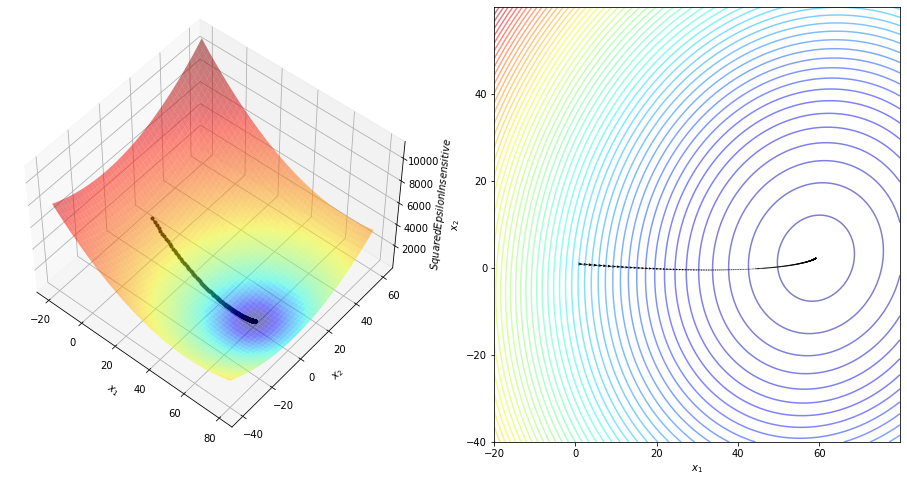

In [98]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [99]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svr_squared_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,nr_train_sv,nr_val_sv
sgd,1,0.100000,0.431650,0.978126,0.973976,351,66,32
sgd,1,0.200000,0.502981,0.978125,0.973973,348,66,32
sgd,1,0.300000,0.490674,0.978125,0.973972,345,66,32
sgd,10,0.100000,0.059331,0.978184,0.973958,47,66,33
sgd,10,0.200000,0.049581,0.978184,0.973957,45,66,33
sgd,10,0.300000,0.062641,0.978183,0.973955,44,66,33
sgd,100,0.100000,0.007187,-18.813057,-18.646387,5,67,33
sgd,100,0.200000,0.011757,-18.899196,-18.743996,5,67,33
sgd,100,0.300000,0.009181,-18.782077,-18.637810,5,67,33


In [100]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [101]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,nr_train_sv,nr_val_sv
liblinear,1,0.100000,0.001047,0.978134,0.974000,88,67,32
liblinear,1,0.200000,0.001002,0.978132,0.974006,85,66,32
liblinear,1,0.300000,0.000923,0.978130,0.974015,87,66,32
liblinear,10,0.100000,0.003412,0.978183,0.973971,768,66,33
liblinear,10,0.200000,0.003714,0.978183,0.973965,776,66,33
liblinear,10,0.300000,0.003632,0.978183,0.973975,758,66,32
liblinear,100,0.100000,0.005186,0.976943,0.973781,1000,66,33
liblinear,100,0.200000,0.004780,0.978119,0.973252,1000,66,33
liblinear,100,0.300000,0.004555,0.977854,0.974064,1000,65,32


In [102]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results, ignore_index=True)
primal_svr_squared_eps_cv_results.sort_values(['epsilon', 'C', 'solver'], inplace=True)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', index=False)
primal_svr_squared_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,nr_train_sv,nr_val_sv
liblinear,1,0.100000,0.001047,0.978134,0.974000,88,67,32
sgd,1,0.100000,0.431650,0.978126,0.973976,351,66,32
liblinear,10,0.100000,0.003412,0.978183,0.973971,768,66,33
sgd,10,0.100000,0.059331,0.978184,0.973958,47,66,33
liblinear,100,0.100000,0.005186,0.976943,0.973781,1000,66,33
sgd,100,0.100000,0.007187,-18.813057,-18.646387,5,67,33
liblinear,1,0.200000,0.001002,0.978132,0.974006,85,66,32
sgd,1,0.200000,0.502981,0.978125,0.973973,348,66,32
liblinear,10,0.200000,0.003714,0.978183,0.973965,776,66,33
sgd,10,0.200000,0.049581,0.978184,0.973957,45,66,33
